In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from xml.etree import ElementTree as ET
import os
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [3]:
def random_color():
    return [random.randint(0, 255) for _ in range(3)]

### Image Processing

In [5]:
# 分割，縮放，拼接圖片
def get_random_data(image_list, input_shape):
    
    h, w = input_shape  # resize後的尺寸
    
    # 設定拼接後的分割線位置
    min_offset_x = 0.4
    min_offset_y = 0.4  
    scale_low = 1 - min(min_offset_x, min_offset_y)  # 0.6
    scale_high = scale_low + 0.2  # 0.8
 
    image_datas = []  # images
    box_datas = []  # bounding box
    index = 0  # 第幾張圖(會放在不同位置)
    
    # 圖像分割
    for frame_list in image_list:
        
        frame = frame_list[0]  # 取出image
        box = np.array(frame_list[1:])  # 取出bounding box和label
 
        ih, iw = frame.shape[0:2]  # 原始圖片的寬高
        
        cx = (box[0,:,0] + box[0,:,2]) // 2  # bounding box中心x
        cy = (box[0,:,1] + box[0,:,3]) // 2  # bounding box中心y
 
        # 縮放圖像資訊
        new_ar = w/h  # 縮放後的寬高比
        scale = np.random.uniform(scale_low, scale_high)   # 縮放0.6-0.8倍
        # 縮放寬高
        nh = int(scale * h)  # 先縮放h維度
        nw = int(nh * new_ar)  # 依據原始寬高比例縮放w維度
        
        # resize
        frame = cv2.resize(frame, (nw,nh))
        
        # 調整中心點座標
        cx = cx * nw/iw 
        cy = cy * nh/ih 
 
        # 調整bounding box
        bw = (box[0,:,2] - box[0,:,0]) * nw/iw
        bh = (box[0,:,3] - box[0,:,1]) * nh/ih
        
        # 創建448x448的背景板
        new_frame = np.zeros((h,w,3), np.uint8)
        
        # 根據第幾張圖片放在不同位置
        if index==0: new_frame[0:nh, 0:nw] = frame   # 左上
        elif index==1: new_frame[0:nh, w-nw:w] = frame  # 右上
        elif index==2: new_frame[h-nh:h, 0:nw] = frame  # 左下
        elif index==3: new_frame[h-nh:h, w-nw:w] = frame  # 右下
 
        # 修正bounding box的位置
        if index==0:  # 左上
            box[0,:,0] = cx - bw // 2  # x1
            box[0,:,1] = cy - bh // 2  # y1
            box[0,:,2] = cx + bw // 2  # x2
            box[0,:,3] = cy + bh // 2  # y2         
        
        if index==1:  # 右上
            box[0,:,0] = cx - bw // 2 + w - nw  # x1
            box[0,:,1] = cy - bh // 2  # y1
            box[0,:,2] = cx + bw // 2 + w - nw # x2
            box[0,:,3] = cy + bh // 2  # y2
        
        if index==2:  # 左下
            box[0,:,0] = cx - bw // 2  # x1
            box[0,:,1] = cy - bh // 2 + h - nh  # y1
            box[0,:,2] = cx + bw // 2  # x2
            box[0,:,3] = cy + bh // 2 + h - nh  # y2
 
        if index==3:  # 右下
            box[0,:,0] = cx - bw // 2 + w - nw # x1
            box[0,:,1] = cy - bh // 2 + h - nh # y1
            box[0,:,2] = cx + bw // 2 + w - nw # x2
            box[0,:,3] = cy + bh // 2 + h - nh  # y2
    
        index = index + 1  # 下一張圖片
        
        # 保存處理後的image和bounding box資訊
        image_datas.append(new_frame)
        box_datas.append(box)
    
    # 檢查處理後的image和bounding box
    # for image, boxes in zip(image_datas, box_datas):
        
    #     # 複製原圖
    #     image_copy = image.copy()
        
    #     # 繪製bounding box
    #     for box in boxes[0]:  
    #         x1, y1, x2, y2, label = box
    #         color = random_color()
    #         cv2.rectangle(image_copy, (x1,y1), (x2,y2), color, 2, cv2.LINE_AA)
    #         t_size = cv2.getTextSize(classes_name[int(label)], 0, fontScale=1 / 3, thickness=1)[0]
    #         c1 = int(x1), int(y1)
    #         c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
    #         cv2.rectangle(image_copy, c1, c2, color, -1, cv2.LINE_AA)
    #         cv2.putText(image_copy, classes_name[int(label)], (int(x1), int(y1)-2), 0, 1 / 3, (255, 255, 255), thickness=1, lineType=cv2.LINE_AA)
    #     plt.imshow(image_copy)
    #     plt.axis('off')
    #     plt.show()

    # 把四張圖拼接在一起
    # 在指定範圍中選擇橫縱向分割線
    cutx = np.random.randint(int(w*min_offset_x), int(w*(1-min_offset_x)))
    cuty = np.random.randint(int(h*min_offset_y), int(h*(1-min_offset_y)))        
    
    # 創建448x448的背景板用於拼接四張圖片
    new_image = np.zeros((h,w,3), np.uint8)
    new_image[:cuty, :cutx, :] = image_datas[0][:cuty, :cutx, :]
    new_image[:cuty, cutx:, :] = image_datas[1][:cuty, cutx:, :]
    new_image[cuty:, :cutx, :] = image_datas[2][cuty:, :cutx, :]
    new_image[cuty:, cutx:, :] = image_datas[3][cuty:, cutx:, :]
    
    # 顯示拼接後的圖片
    # plt.imshow(new_image)
    # plt.axis('off')
    # plt.show()

    # 複製拼接後圖片
    final_image_copy = new_image.copy()
    
    # 顯示拼接後的所有bounding box
    # for boxes in box_datas:
    #     for box in boxes[0]:  
    #         x1, y1, x2, y2, label = box
    #         color = random_color()
    #         cv2.rectangle(final_image_copy, (x1,y1), (x2,y2), color, 2, cv2.LINE_AA)
    #         t_size = cv2.getTextSize(classes_name[int(label)], 0, fontScale=1 / 3, thickness=1)[0]
    #         c1 = int(x1), int(y1)
    #         c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
    #         cv2.rectangle(final_image_copy, c1, c2, color, -1, cv2.LINE_AA)
    #         cv2.putText(final_image_copy, classes_name[int(label)], (int(x1), int(y1)-2), 0, 1 / 3, (255, 255, 255), thickness=1, lineType=cv2.LINE_AA)
    # plt.imshow(final_image_copy)
    # plt.axis('off')
    # plt.show()

    # 處理超過分割線的bounding boxes
    new_boxes = merge_bboxes(box_datas, cutx, cuty)
    
    # 複製合併後圖像
    modify_image_copy = new_image.copy()
    
    # 繪製修正後的bounding boxes
    produced_data = ""
    for boxes in new_boxes:
        for box in boxes:
            x1, y1, x2, y2, label = box
            # color = random_color()
            # cv2.rectangle(modify_image_copy, (x1,y1), (x2,y2), color, 2, cv2.LINE_AA)
            # t_size = cv2.getTextSize(classes_name[int(label)], 0, fontScale=1 / 3, thickness=1)[0]
            # c1 = int(x1), int(y1)
            # c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
            # cv2.rectangle(modify_image_copy, c1, c2, color, -1, cv2.LINE_AA)
            # cv2.putText(modify_image_copy, classes_name[int(label)], (int(x1), int(y1)-2), 0, 1 / 3, (255, 255, 255), thickness=1, lineType=cv2.LINE_AA)
            produced_data += f" {x1} {y1} {x2} {y2} {label}"
    # plt.imshow(modify_image_copy)
    # plt.axis('off')
    # plt.show()
    return new_image, produced_data


# 處理超過分割線的bounding boxes
def merge_bboxes(bboxes, cutx, cuty):
    
    # 修改後的bounding box
    merge_box = []
    
    for i, box in enumerate(bboxes):
        
        # 每張image需要刪掉的boudning box
        index_list = []
        
        # 遍歷所有bounding box,index代表第幾個
        for index, box in enumerate(box[0]):     

            x1, y1, x2, y2, label = box
            
            # 左上圖，修改右側及下側的分割線
            if i== 0:
                # 如果bounding box的左上座標不在分割線內就刪除
                if x1 > cutx or y1 > cuty:
                    index_list.append(index) 
    
                # 如果bounding box的右下座標不在分割線內，取分割線邊界為新右下座標
                if y2 >= cuty and y1 <= cuty:
                    y2 = cuty
                    # 修正後bounding box高度過矮則也刪除
                    if y2-y1 < 20:
                        index_list.append(index)
                
                if x2 >= cutx and x1 <= cutx:
                    x2 = cutx
                    # 修正後bounding box寬度過窄則也刪除
                    if x2-x1 < 20:
                        index_list.append(index) 
            
            # 右上圖，修改左側及下側的分割線
            if i == 1:
                if x2 < cutx or y1 > cuty:
                    index_list.append(index) 
                
                if y2 >= cuty and y1 <= cuty:
                    y2 = cuty
                    if y2-y1 < 20:
                        index_list.append(index)
                
                if x1 <= cutx and x2 >= cutx:
                    x1 = cutx
                    if x2-x1 < 20:
                        index_list.append(index) 
            
            # 左下圖，修改右側及上側的分割線
            if i == 2:
                if x1 > cutx or y2 < cuty:
                    index_list.append(index) 
                
                if y1 <= cuty and y2 >= cuty:
                    y1 = cuty
                    if y2-y1 < 20:
                        index_list.append(index) 
                
                if x1 <= cutx and x2 >= cutx:
                    x2 = cutx
                    if x2-x1 < 20:
                        index_list.append(index) 
            
            # 右下圖，修改左側及上側的分割線
            if i == 3:
                if x2 < cutx or y2 < cuty:
                    index_list.append(index) 
                
                if x1 <= cutx and x2 >= cutx:
                    x1 = cutx
                    if x2-x1 < 20:
                        index_list.append(index) 
                
                if y1 <= cuty and y2 >= cuty:
                    y1 = cuty
                    if y2-y1 < 20:
                        index_list.append(index) 
                   
            # 更新bounding box資訊
            bboxes[i][0][index] = [x1, y1, x2, y2, label] 
       
        # 刪除超出分割線的bounding box
        merge_box.append(np.delete(bboxes[i][0], index_list, axis=0))
 
    return merge_box


### Test mosaic (this cell can be ignored)

In [6]:
random_pick = np.arange(start=0, stop=5011)
np.random.shuffle(random_pick)
print(random_pick[:10])

[2004 4173 3104 3161 4283  826 3966 3785 1107 4935]


In [9]:
images_name = os.listdir('./datasets/VOCdevkit_train/VOC2007/JPEGImages/')
annotations_name = os.listdir('./datasets/VOCdevkit_train/VOC2007/Annotations/')

image_dir = './datasets/VOCdevkit_train/VOC2007/JPEGImages/'
annotation_dir = './datasets/VOCdevkit_train/VOC2007/Annotations/'

# training_data_file = open("./datasets/pascal_voc_training_data.txt", "r")

image_list = []  # 存放image和bounding box訊息

# random_pick = np.random.randint(low=0, high=5011, size=4)
random_pick = np.arange(start=0, stop=5011)
np.random.shuffle(random_pick)

count = 0
for i in random_pick:

    image_boxes = []  # bounding box

    image_path = image_dir + images_name[i]
    annotation_path = annotation_dir + annotations_name[i]

    image = cv2.imread(image_path)  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 使用library讀取bounding box
    with open(annotation_path, 'r') as new_f:
        #  getroot()取得root
        root = ET.parse(annotation_path).getroot()
    
    obj_flag = 0
    # findall找物件，find找各物件內的資訊
    for obj in root.findall('object'):
        obj_name = obj.find('name').text   # object name
        if(obj_name in ['person', 'car', 'chair']):
            obj_flag = 1
            break
        object_class = classes_name.index(obj_name)
        bndbox = obj.find('bndbox')
        left = eval(bndbox.find('xmin').text)    
        top = eval(bndbox.find('ymin').text)     
        right = eval(bndbox.find('xmax').text)   
        bottom = eval(bndbox.find('ymax').text)  
 
        image_boxes.append([left, top, right, bottom, object_class])  # [[x1,y1,x2,y2,label],[..],[..]]
        # object_classes.append(object_class)

    if(obj_flag): continue
        
    # 保存image和對應bounding box
    image_list.append([image, image_boxes])
    # produced_data.append(images_name[i])
    count += 1
    if(count == 4): break


# 分割，縮放，拼接圖片，指定尺寸448x448
new_image, new_data = get_random_data(image_list, input_shape=[448,448])

 123 111 192 199 12 123 60 192 199 12 292 55 336 109 15 0 261 192 437 2 192 287 443 429 18


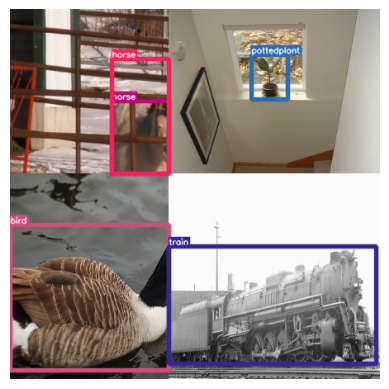

In [10]:
# check result whether is correct
print(new_data)
check_data = new_data.split()
objs = [check_data[i:i + 5] for i in range(0, len(check_data), 5)]
for x, y, x_, y_, label in objs:
    # print(x, y, x_, y_, label)
    color = random_color()
    cv2.rectangle(new_image, (int(x), int(y)), (int(x_) ,int(y_)), color, 3, cv2.LINE_AA)
    t_size = cv2.getTextSize(classes_name[int(label)], 0, fontScale=1 / 3, thickness=1)[0]
    c1 = int(x), int(y)
    c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
    cv2.rectangle(new_image, c1, c2, color, -1, cv2.LINE_AA)
    cv2.putText(new_image, classes_name[int(label)], (int(x), int(y)-2), 0, 1 / 3, (255, 255, 255), thickness=1, lineType=cv2.LINE_AA)

plt.imshow(new_image)
plt.axis('off')
plt.show()

### Produced data

In [16]:
images_name = os.listdir('./datasets/VOCdevkit_train/VOC2007/JPEGImages/')
annotations_name = os.listdir('./datasets/VOCdevkit_train/VOC2007/Annotations/')

image_dir = './datasets/VOCdevkit_train/VOC2007/JPEGImages/'
annotation_dir = './datasets/VOCdevkit_train/VOC2007/Annotations/'

now_image_index = 1003750

for num in range(250):
    image_list = []  # 存放image和bounding box訊息

    # random_pick = np.random.randint(low=0, high=5011, size=4)
    random_pick = np.arange(start=0, stop=5011)
    np.random.shuffle(random_pick)

    count = 0
    for i in random_pick:

        image_boxes = []  # bounding box

        image_path = image_dir + images_name[i]
        annotation_path = annotation_dir + annotations_name[i]

        image = cv2.imread(image_path)  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 使用library讀取bounding box
        with open(annotation_path, 'r') as new_f:
            #  getroot()取得root
            root = ET.parse(annotation_path).getroot()
        
        obj_flag = 0
        # findall找物件，find找各物件內的資訊
        for obj in root.findall('object'):
            obj_name = obj.find('name').text   # object name
            # if(obj_name in ['person', 'chair', 'cat', 'car', 'bottle', 'boat', 'bird', 'aeroplane', 'train', 'sheep', 'pottledplant', 'dog', 'cow']):
            if(obj_name not in ['diningtable', 'bicycle', 'horse', 'bus']):
                obj_flag = 1
                break
            object_class = classes_name.index(obj_name)
            bndbox = obj.find('bndbox')
            left = eval(bndbox.find('xmin').text)    
            top = eval(bndbox.find('ymin').text)     
            right = eval(bndbox.find('xmax').text)   
            bottom = eval(bndbox.find('ymax').text)  
        
            image_boxes.append([left, top, right, bottom, object_class])  # [[x1,y1,x2,y2,label],[..],[..]]
            # object_classes.append(object_class)

        if(obj_flag): continue

        # 保存image和對應bounding box
        image_list.append([image, image_boxes])
        # produced_data.append(images_name[i])
        count += 1
        if(count == 4): break
        

    # 分割，縮放，拼接圖片，指定尺寸448x448
    new_image, new_data = get_random_data(image_list, input_shape=[448,448])

    # 儲存圖片和bounding box資訊
    with open("./datasets/pascal_voc_training_data.txt", "a") as file:
        new_image_name = f"{now_image_index + num + 1}.jpg"
        new_rgb_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(image_dir + new_image_name, new_rgb_image)
        new_data = new_data.strip()
        file.write(new_image_name + f" {new_data}" + '\n')

### Check Produced Data

1000292.jpg 170 1 238 127 9 69 113 238 198 9 1 1 73 185 9 238 20 436 198 7 238 3 447 198 17 1 198 238 378 7 0 198 238 444 11 249 198 429 281 7


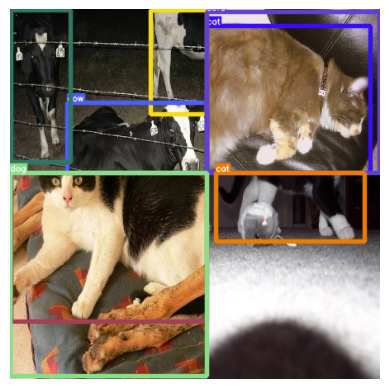

009117.jpg 188 27 500 373 11


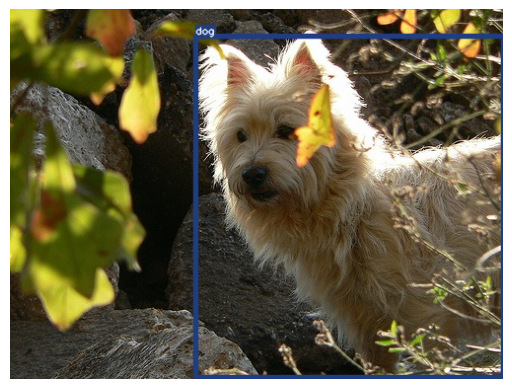

002468.jpg 259 33 410 166 2 45 172 178 330 2


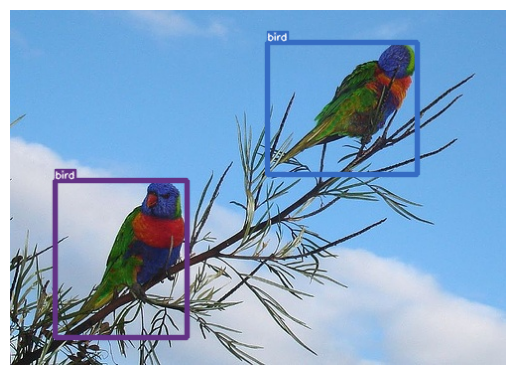

1002438.jpg 111 215 151 235 15 208 166 374 235 9 230 22 446 235 9 1 235 182 387 3 223 235 325 303 18


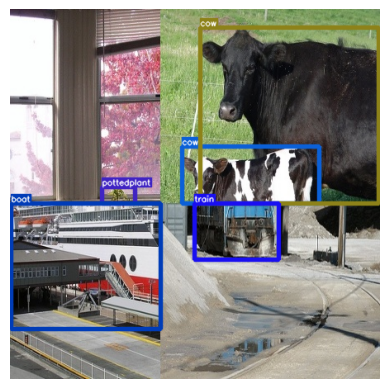

In [9]:
tl = 1
tk = 1

with open("./datasets/more_data_train.txt", "r") as file:
    lines = file.readlines()

random_pick = np.random.randint(low=0, high=len(lines), size=4)

show_lines = [lines[i] for i in random_pick]

for i, line in enumerate(show_lines):
    line = line.strip()
    print(line)
    line = line.split()
    img_name = line[0]
    img = cv2.imread(f'./datasets/VOCdevkit_train/VOC2007/MosaicImages/{img_name}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    objs = [line[i:i + 5] for i in range(1, len(line), 5)]
    for x, y, x_, y_, label in objs:
        color = random_color()
        cv2.rectangle(img, (int(x), int(y)), (int(x_) ,int(y_)), color, 3, cv2.LINE_AA)
        t_size = cv2.getTextSize(classes_name[int(label)], 0, fontScale=tl / 3, thickness=tk)[0]
        c1 = int(x), int(y)
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)
        cv2.putText(img, classes_name[int(label)], (int(x), int(y)-2), 0, tl / 3, (255, 255, 255), thickness=tk, lineType=cv2.LINE_AA)

    plt.imshow(img)
    plt.axis('off')
    plt.show()